# Recurrent Neural Networks

本次作業是要讓同學接觸 NLP 當中一個簡單的 task —— 語句分類（文本分類）

給定一個語句，判斷他有沒有惡意（負面標 0，正面標 1）


## **goal**

----- strong baseline -----
0.82171   
----- simple baseline -----
0.76978

## **可以改的地方**
###  1. def train_word2vec(x):  訓練 word to vector 的 word embedding   
     model = word2vec.Word2Vec(x, size=250, window=5, min_count=5, workers=12, iter=10, sg=1) #原本的

### 2. class LSTM_Net(nn.Module):  
     def __init__(self, embedding, embedding_dim, hidden_dim, num_layers,  dropout=0.5, fix_embedding=True)

### 3. training
    def training(batch_size, n_epoch, lr, model_dir, train, valid, model, device)
### 4. Ensemble Learning   
    Reference: http://violin-tao.blogspot.com/2018/01/ml-ensemble.html

In [1]:
# 設定路徑
path_prefix = './'

### Download Dataset
有三個檔案，分別是 training_label.txt、training_nolabel.txt、testing_data.txt

- training_label.txt：有 label 的 training data（句子配上 0 or 1，+++$+++ 只是分隔符號，不要理它）
    - e.g., 1 +++$+++ are wtf ... awww thanks !

- training_nolabel.txt：沒有 label 的 training data（只有句子），用來做 semi-supervised learning
    - ex: hates being this burnt !! ouch

- testing_data.txt：你要判斷 testing data 裡面的句子是 0 or 1

    >id,text

    >0,my dog ate our dinner . no , seriously ... he ate it .

    >1,omg last day sooon n of primary noooooo x im gona be swimming out of school wif the amount of tears am gona cry

    >2,stupid boys .. they ' re so .. stupid !

In [ ]:
!gdown --id '1lz0Wtwxsh5YCPdqQ3E3l_nbfJT1N13V8' --output data.zip
!unzip data.zip
!ls

In [3]:
# this is for filtering the warnings
# 警告過濾器可以用來控制是否發出警告消息，警告過濾器是一些匹配規則和動作的序列。
# 可以通過調用 filterwarnings() 將規則添加到過濾器，並通過調用 resetwarnings() 將其重置為默認狀態。

import warnings
warnings.filterwarnings('ignore')

### Utils

In [5]:
import torch
import numpy as np
import pandas as pd
import torch.optim as optim
import torch.nn.functional as F
import time
import random

# 固定隨機種子
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(0)

In [6]:
# utils.py
# 這個 block 用來先定義一些等等常用到的函式

def load_training_data(method, path='training_label.txt'):
  if (method == 'unsupervised'):
    # 把 training 時需要的 data 讀進來
    # 如果是 'training_label.txt'，需要讀取 label，如果是 'training_nolabel.txt'，不需要讀取 label
    if 'training_label' in path:
        with open(path, 'r') as f:
            lines = f.readlines()
            lines = [line.strip('\n').split(' ') for line in lines]
        x = [line[2:] for line in lines]
        y = [line[0] for line in lines]
        return x, y
    else:
        with open(path, 'r') as f:
            lines = f.readlines()
            x = [line.strip('\n').split(' ') for line in lines]
        return x

################################################################################

  else:
    # 把 training 時需要的 data 讀進來
    # 如果是 'training_label.txt'，需要讀取 label，如果是 'training_nolabel.txt'，不需要讀取 label
    if 'training_label' in path:
        with open(path, 'r') as f:
            lines = f.readlines()
            lines = [line.strip('\n').split(' ') for line in lines]
        x = [line[2:] for line in lines]
        y = [line[0] for line in lines]
        return x, y
    else:
        with open(path, 'r') as f:
            lines = f.readlines()
            x = [line.strip('\n').split(' ') for line in lines]
            y = [outputs[i] for i in range(len(outputs))]
        return x, y

################################################################################

def load_testing_data(path='testing_data'):
    # 把 testing 時需要的 data 讀進來
    with open(path, 'r') as f:
        lines = f.readlines()
        X = ["".join(line.strip('\n').split(",")[1:]).strip() for line in lines[1:]]
        X = [sen.split(' ') for sen in X]
    return X

def evaluation(outputs, labels):
    # outputs => probability (float)
    # labels => labels
    outputs[outputs>=0.5] = 1 # 大於等於 0.5 為無惡意 #原本的
    outputs[outputs<0.5] = 0 # 小於 0.5 為有惡意 #原本的
    correct = torch.sum(torch.eq(outputs, labels)).item()
    return correct

### Train Word to Vector (supervised)

CBOW：From that context, predict the target word (Continuous Bag of Words or CBOW approach)

Skip-Gram：From the target word, predict the context it came from (Skip-gram approach)

In [ ]:
# w2v.py
# 這個 block 是用來訓練 word to vector 的 word embedding
# 注意！這個 block 在訓練 word to vector 時是用 cpu，可能要花到 10 分鐘以上
import os
import numpy as np
import pandas as pd
import argparse
from gensim.models import word2vec

# word2vec使用
# size：特徵向量的維度，預設值為100
# window：代表input word 與預測word的最大距離，若設為1，代表向左向右各看一個詞
# min_count：該詞最少出現幾次，才可以被當作是訓練資料，例如min_count設為5，則出現5次以下的字詞都不會被放進來訓練
# negative：大於0，代表採用negative sampling，設置多少個noise words
#         例如「喜歡 麥當當 蘋果派 又 甜 又 香」，以「蘋果派」向左向右各看一個詞，就是「麥當當 蘋果派 又」
# workers：多執行緒的數量
# iter：迭代數量，預設為5
# sg：演算法，預設為0，代表是CBOW，若設為1則是使用Skip-Gram

def train_word2vec(x):
    # 訓練 word to vector 的 word embedding
    model = word2vec.Word2Vec(x, size=250, window=5, min_count=6, workers=12, iter=10, sg=1)
    return model

if __name__ == "__main__":
    # 開始做字詞切割，有點像 1-gram
    # training_label.txt 有 200,000 左右行，每行的詞數不等
    # training_nolabel.txt 有 1,200,000 左右行，每行的詞數不等
    print("loading training data ...")
    train_x, y = load_training_data('unsupervised', 'training_label.txt', )
    train_x_no_label = load_training_data('unsupervised', 'training_nolabel.txt')
    ############################################################################  
    print("loading testing data ...")
    test_x = load_testing_data('testing_data.txt')
    model = train_word2vec(train_x + test_x) #supervised
    
    print("saving model ...")
    model.save(os.path.join(path_prefix, 'w2v_all.model'))

### Data Preprocess

In [8]:
# preprocess.py
# 這個 block 用來做 data 的預處理
from torch import nn
from gensim.models import Word2Vec

class Preprocess():
    def __init__(self, sentences, sen_len, w2v_path="./w2v.model"):
        self.w2v_path = w2v_path
        self.sentences = sentences
        self.sen_len = sen_len
        self.idx2word = []
        self.word2idx = {}
        self.embedding_matrix = []
    def get_w2v_model(self):
        # 把之前訓練好的 word to vec 模型讀進來
        self.embedding = Word2Vec.load(self.w2v_path)
        self.embedding_dim = self.embedding.vector_size
    def add_embedding(self, word):
        # 把 word 加進 embedding，並賦予他一個隨機生成的 representation vector
        # word 只會是 "<PAD>" 或 "<UNK>"
          # PAD : 因為每個 batch 的單字長度要一致，所以我們要用 PAD 來填充過短的單字，主要用来进行字符补全。
          # UNK : 如果輸入字元沒在字典裡出現過，就用 UNK 的索引替代它，用来替代一些未出现过的词或者低频词。
        vector = torch.empty(1, self.embedding_dim)
        torch.nn.init.uniform_(vector)
        self.word2idx[word] = len(self.word2idx)
        self.idx2word.append(word)
        self.embedding_matrix = torch.cat([self.embedding_matrix, vector], 0)
    def make_embedding(self, load=True):
        print("Get embedding ...")
        # 取得訓練好的 Word2vec word embedding
        if load:
            print("loading word to vec model ...")
            self.get_w2v_model()
        else:
            raise NotImplementedError
        # 製作一個 word2idx 的 dictionary
        # 製作一個 idx2word 的 list
        # 製作一個 word2vector 的 list
        for i, word in enumerate(self.embedding.wv.vocab):
            print('get words #{}'.format(i+1), end='\r')
            #e.g. self.word2index['he'] = 1 
            #e.g. self.index2word[1] = 'he'
            #e.g. self.vectors[1] = 'he' vector
            self.word2idx[word] = len(self.word2idx)
            self.idx2word.append(word)
            self.embedding_matrix.append(self.embedding[word])
        print('')
        self.embedding_matrix = torch.tensor(self.embedding_matrix)
        # 將 "<PAD>" 跟 "<UNK>" 加進 embedding 裡面
        self.add_embedding("<PAD>")
        self.add_embedding("<UNK>")
        print("total words: {}".format(len(self.embedding_matrix)))
        return self.embedding_matrix
    def pad_sequence(self, sentence):
        # 將每個句子變成一樣的長度
        if len(sentence) > self.sen_len:
            sentence = sentence[:self.sen_len]
        else:
            pad_len = self.sen_len - len(sentence)
            for _ in range(pad_len):
                sentence.append(self.word2idx["<PAD>"])
        assert len(sentence) == self.sen_len
        return sentence
    def sentence_word2idx(self):
        # 把句子裡面的字轉成相對應的 index
        sentence_list = []
        for i, sen in enumerate(self.sentences):
            print('sentence count #{}'.format(i+1), end='\r')
            sentence_idx = []
            for word in sen:
                if (word in self.word2idx.keys()):
                    sentence_idx.append(self.word2idx[word])
                else:
                    sentence_idx.append(self.word2idx["<UNK>"])
            # 將每個句子變成一樣的長度
            sentence_idx = self.pad_sequence(sentence_idx)
            sentence_list.append(sentence_idx)
        return torch.LongTensor(sentence_list)
    def labels_to_tensor(self, y):
        # 把 labels 轉成 tensor
        y = [int(label) for label in y]
        return torch.LongTensor(y)

### Dataset

In [9]:
# data.py
# 實作了 dataset 所需要的 '__init__', '__getitem__', '__len__'
# 好讓 dataloader 能使用
import torch
from torch.utils import data

class TwitterDataset(data.Dataset):
    """
    Expected data shape like:(data_num, data_len)
    Data can be a list of numpy array or a list of lists
    input data shape : (data_num, seq_len, feature_dim)
    
    __len__ will return the number of data
    """
    def __init__(self, X, y):
        self.data = X
        self.label = y
    def __getitem__(self, idx):
        if self.label is None: return self.data[idx]
        return self.data[idx], self.label[idx]
    def __len__(self):
        return len(self.data)

### Model

In [10]:
# model.py
# 這個 block 是要拿來訓練的模型
import torch
from torch import nn
class LSTM_Net(nn.Module):
    def __init__(self, embedding, embedding_dim, hidden_dim, num_layers, dropout=0.5, fix_embedding=True):
        super(LSTM_Net, self).__init__()
        # 製作 embedding layer
        self.embedding = torch.nn.Embedding(embedding.size(0),embedding.size(1))
        self.embedding.weight = torch.nn.Parameter(embedding)
        # 是否將 embedding fix 住，如果 fix_embedding 為 False，在訓練過程中，embedding 也會跟著被訓練
        self.embedding.weight.requires_grad = False if fix_embedding else True
        self.embedding_dim = embedding.size(1)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.classifier = nn.Sequential( nn.Dropout(dropout),
                                         nn.Linear(hidden_dim, 1),
                                         nn.Sigmoid() )
    def forward(self, inputs):
        inputs = self.embedding(inputs)
        x, _ = self.lstm(inputs, None)
        # x 的 dimension (batch, seq_len, hidden_size)
        # 取用 LSTM 最後一層的 hidden state
        x = x[:, -1, :] 
        x = self.classifier(x)
        return x

### Train

In [11]:
# train.py
# 這個 block 是用來訓練模型的
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
x_epoch = []
y_train_acc = []
y_val_acc = []
def training(batch_size, n_epoch, lr, model_dir, train, valid, model, device):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('\nstart training, parameter total:{}, trainable:{}\n'.format(total, trainable))
    model.train() # 將 model 的模式設為 train，這樣 optimizer 就可以更新 model 的參數
    criterion = nn.BCELoss() # 定義損失函數，這裡我們使用 binary cross entropy loss
    t_batch = len(train) 
    v_batch = len(valid) 
    optimizer = optim.Adam(model.parameters(), lr=lr) # 將模型的參數給 optimizer，並給予適當的 learning rate
    total_loss, total_acc, best_acc = 0, 0, 0
    import matplotlib.pyplot as plt
    for epoch in range(n_epoch):
        x_epoch.append(epoch)
        epoch_start_time = time.time()
        total_loss, total_acc = 0, 0
        # 這段做 training
        for i, (inputs, labels) in enumerate(train):
            inputs = inputs.to(device, dtype=torch.long) # device 為 "cuda"，將 inputs 轉成 torch.cuda.LongTensor
            labels = labels.to(device, dtype=torch.float) # device為 "cuda"，將 labels 轉成 torch.cuda.FloatTensor，因為等等要餵進 criterion，所以型態要是 float
            optimizer.zero_grad() # 由於 loss.backward() 的 gradient 會累加，所以每次餵完一個 batch 後需要歸零
            outputs = model(inputs) # 將 input 餵給模型
            outputs = outputs.squeeze() # 去掉最外面的 dimension，好讓 outputs 可以餵進 criterion()
            loss = criterion(outputs, labels) # 計算此時模型的 training loss
            loss.backward() # 算 loss 的 gradient
            optimizer.step() # 更新訓練模型的參數
            correct = evaluation(outputs, labels) # 計算此時模型的 training accuracy
            total_acc += (correct / batch_size)
            total_loss += loss.item()
            print('[ Epoch{}: {}/{} ] loss:{:.3f} acc:{:.3f} '.format(
            	epoch+1, i+1, t_batch, loss.item(), correct*100/batch_size), end='\r')
        print('\nTrain | Loss:{:.5f} Acc: {:.3f}'.format(total_loss/t_batch, total_acc/t_batch*100))
        y_train_acc.append(total_acc/t_batch*100)

        # 這段做 validation
        model.eval() # 將 model 的模式設為 eval，這樣 model 的參數就會固定住
        with torch.no_grad():
            total_loss, total_acc = 0, 0
            for i, (inputs, labels) in enumerate(valid):
                inputs = inputs.to(device, dtype=torch.long) # device 為 "cuda"，將 inputs 轉成 torch.cuda.LongTensor
                labels = labels.to(device, dtype=torch.float) # device 為 "cuda"，將 labels 轉成 torch.cuda.FloatTensor，因為等等要餵進 criterion，所以型態要是 float
                outputs = model(inputs) # 將 input 餵給模型
                outputs = outputs.squeeze() # 去掉最外面的 dimension，好讓 outputs 可以餵進 criterion()
                loss = criterion(outputs, labels) # 計算此時模型的 validation loss
                correct = evaluation(outputs, labels) # 計算此時模型的 validation accuracy
                total_acc += (correct / batch_size)
                total_loss += loss.item()

            print("Valid | Loss:{:.5f} Acc: {:.3f} ".format(total_loss/v_batch, total_acc/v_batch*100))
            if total_acc > best_acc:
                # 如果 validation 的結果優於之前所有的結果，就把當下的模型存下來以備之後做預測時使用
                best_acc = total_acc
                torch.save(model, "{}/ckpt.model".format(model_dir))
                print('saving model with acc {:.3f}'.format(total_acc/v_batch*100))
        y_val_acc.append(total_acc/v_batch*100)
        print('epoch =', epoch, ', time cost = ', time.time()-epoch_start_time, ' sec(s)')
        print('-----------------------------------------------')
        model.train() # 將 model 的模式設為 train，這樣 optimizer 就可以更新 model 的參數（因為剛剛轉成 eval 模式）
    plt.plot(x_epoch, y_train_acc)
    plt.plot(x_epoch, y_val_acc)
    plt.title("acc_learning_curve") # title
    plt.ylabel("acc") # y label
    plt.xlabel("epoch") # x label 
    plt.show()

### Main

In [ ]:
# main.py
import os
import torch
import argparse
import numpy as np
from torch import nn
from gensim.models import word2vec
from sklearn.model_selection import train_test_split

# 通過 torch.cuda.is_available() 的回傳值進行判斷是否有使用 GPU 的環境，如果有的話 device 就設為 "cuda"，沒有的話就設為 "cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 處理好各個 data 的路徑
train_with_label = os.path.join(path_prefix, 'training_label.txt')
train_no_label = os.path.join(path_prefix, 'training_nolabel.txt')
testing_data = os.path.join(path_prefix, 'testing_data.txt')
w2v_path = os.path.join(path_prefix, 'w2v_all.model') # 處理 word to vec model 的路徑

# 定義句子長度、要不要固定 embedding、batch 大小、要訓練幾個 epoch、learning rate 的值、model 的資料夾路徑
sen_len = 40
fix_embedding = True # fix embedding during training
batch_size = 128
epoch = 15
lr = 0.001
# model_dir = os.path.join(path_prefix, 'model/') # model directory for checkpoint model
model_dir = path_prefix # model directory for checkpoint model

print("loading data ...") # 把 'training_label.txt' 跟 'training_nolabel.txt' 讀進來
train_x, y = load_training_data('unsupervised', train_with_label)
train_x_no_label = load_training_data('unsupervised', train_no_label)
################################把 labeled 拿來用################################

# 對 input 跟 labels 做預處理
preprocess = Preprocess(train_x, sen_len, w2v_path=w2v_path)
embedding = preprocess.make_embedding(load=True)
train_x = preprocess.sentence_word2idx()
y = preprocess.labels_to_tensor(y)

################################################################################

# 製作一個 model 的對象
model = LSTM_Net(embedding, embedding_dim=250, hidden_dim=150, num_layers=1, dropout=0.5, fix_embedding=fix_embedding)
model = model.to(device) # device為 "cuda"，model 使用 GPU 來訓練（餵進去的 inputs 也需要是 cuda tensor）

# 把 data 分為 training data 跟 validation data（將一部份 training data 拿去當作 validation data）
# labeled training data 數量：20萬
# unlabeled training data 數量：小於 120 萬，看自己設的閾值
X_train, X_val, y_train, y_val = train_x[20000:], train_x[:20000], y[20000:], y[:20000]
# X_train, X_val, y_train, y_val = train_x[100000:300000], train_x[:100000], y[100000:300000], y[:100000]

# 把 data 做成 dataset 供 dataloader 取用
train_dataset = TwitterDataset(X=X_train, y=y_train)
val_dataset = TwitterDataset(X=X_val, y=y_val)

# 把 data 轉成 batch of tensors
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = batch_size,
                                            shuffle = True,
                                            num_workers = 8)

val_loader = torch.utils.data.DataLoader(dataset = val_dataset,
                                            batch_size = batch_size,
                                            shuffle = False,
                                            num_workers = 8)

# 開始訓練
training(batch_size, epoch, lr, model_dir, train_loader, val_loader, model, device)

### Semi-suprivised with unlabeled data

In [13]:
# semi.py
# 這個 block 用來對 train_x_no_label.txt 做預測
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
# good = 有信心資料，bad = 沒信心資料
def semi_supervised(batch_size, train_x_no_label_loader, model, device, good, bad):
    model.eval()
    ret_output = []
    good = 0
    bad = 0
    with torch.no_grad():
        for i, inputs in enumerate(train_x_no_label_loader):
            inputs = inputs.to(device, dtype=torch.long)
            outputs = model(inputs)
            outputs = outputs.squeeze()
            # print(i, inputs, len(inputs), outputs, len(outputs))
            for j in range(len(outputs)):
              # print(len(outputs))
              if(outputs[j]>=0.8):
                outputs[j] = 1
                good += 1
              elif(outputs[j]<=0.2):
                outputs[j] = 0
                good += 1
              else:
                outputs[j] = 2000000
                bad += 1
            ret_output += outputs.int().tolist()        
    return ret_output, good, bad

### Predict train_x_no_label and Write to csv file

In [ ]:
# 開始測試模型並做預測
print("loading training_nolabel data ...")
train_x_no_label = load_training_data('unsupervised', train_no_label)
preprocess = Preprocess(train_x_no_label, sen_len, w2v_path=w2v_path)
embedding = preprocess.make_embedding(load=True)
train_x_no_label = preprocess.sentence_word2idx()
train_x_no_label_dataset = TwitterDataset(X=train_x_no_label, y=None)
train_x_no_label_loader = torch.utils.data.DataLoader(dataset = train_x_no_label_dataset,
                                            batch_size = batch_size,
                                            shuffle = False,
                                            num_workers = 8)
print('\nload model ...')
model = torch.load(os.path.join(model_dir, 'ckpt.model'))
good = 0
bad = 0
outputs, good, bad = semi_supervised(batch_size, train_x_no_label_loader, model, device, good, bad)
print('num of good = ', good)
print('num of bad = ', bad)

# 寫到 csv 檔案供上傳 Kaggle
tmp = pd.DataFrame({"id":[str(i) for i in range(len(train_x_no_label))],"label":outputs})
print("save csv ...")
tmp.to_csv(os.path.join(path_prefix, 'semi_supervised.csv'), index=False)
print("Finish semi_supervised")

使用 label 好的 unlabeled data

In [15]:
def load_training_data(method, path='training_label.txt'):
  if (method == 'unsupervised'):
    # 把 training 時需要的 data 讀進來
    # 如果是 'training_label.txt'，需要讀取 label，如果是 'training_nolabel.txt'，不需要讀取 label
    if 'training_label' in path:
        with open(path, 'r') as f:
            lines = f.readlines()
            lines = [line.strip('\n').split(' ') for line in lines]
        x = [line[2:] for line in lines]
        y = [line[0] for line in lines]
        return x, y
    else:
        with open(path, 'r') as f:
            lines = f.readlines()
            x = [line.strip('\n').split(' ') for line in lines]
        return x
################################################################################
  else:
    # 把 training 時需要的 data 讀進來
    # 如果是 'training_label.txt'，需要讀取 label，如果是 'training_nolabel.txt'，不需要讀取 label
    if 'training_label' in path:
        with open(path, 'r') as f:
            lines = f.readlines()
            lines = [line.strip('\n').split(' ') for line in lines]
        x = [line[2:] for line in lines]
        y = [line[0] for line in lines]
        return x, y
    else:
        import pandas as pd
        outputs = pd.read_csv(path_prefix + 'semi_supervised.csv')
        outputs = outputs.values.tolist()
        with open(path, 'r') as f:
            lines = f.readlines()
            x = [line.strip('\n').split(' ') for line in lines]
            y = [outputs[i][1] for i in range(len(outputs))]
        return x, y
################################################################################

def load_testing_data(path='testing_data'):
    # 把 testing 時需要的 data 讀進來
    with open(path, 'r') as f:
        lines = f.readlines()
        X = ["".join(line.strip('\n').split(",")[1:]).strip() for line in lines[1:]]
        X = [sen.split(' ') for sen in X]
    return X

def evaluation(outputs, labels):
    # outputs => probability (float)
    # labels => labels
    outputs[outputs>=0.5] = 1 # 大於等於 0.5 為無惡意 #原本的
    outputs[outputs<0.5] = 0 # 小於 0.5 為有惡意 #原本的
    correct = torch.sum(torch.eq(outputs, labels)).item()
    return correct

semi word2vec

In [ ]:
# semi
# w2v.py
# 這個 block 是用來訓練 word to vector 的 word embedding
# 注意！這個 block 在訓練 word to vector 時是用 cpu，可能要花到 10 分鐘以上
import os
import numpy as np
import pandas as pd
import argparse
from gensim.models import word2vec

def train_word2vec(x):
    # 訓練 word to vector 的 word embedding
    # model = word2vec.Word2Vec(x, size=250, window=5, min_count=5, workers=12, iter=10, sg=1) #原本的
    model = word2vec.Word2Vec(x, size=250, window=5, min_count=6, workers=12, iter=10, sg=1)
    return model

if __name__ == "__main__":
    # 開始做字詞切割，有點像 1-gram
    # training_label.txt 有 200,000 左右行，每行的詞數不等
    # training_nolabel.txt 有 1,200,000 左右行，每行的詞數不等
    print("loading training data ...")
    train_x, y = load_training_data('unsupervised', 'training_label.txt', )
    ############################################################################  
    #使用 semi #應該要用個函式包起來成為 pretty code
    train_x_no_label, y_semi = load_training_data('semi_supervised', 'training_nolabel.txt')
    # 把沒有信心的 data 不要做 label 資料
    train_x_no_label_good = []
    y_semi_good = []
    for i in range (len(train_x_no_label)):
      if(y_semi[i] == 1 or y_semi[i] == 0):
        train_x_no_label_good.append(train_x_no_label[i])
        y_semi_good.append(y_semi[i])
    ############################################################################
    print("loading testing data ...")
    test_x = load_testing_data('testing_data.txt')

    # 使用 semi-supervised 過 strong
    model = train_word2vec(train_x + train_x_no_label_good + test_x) #semi-supervised
    
    print("saving model ...")
    model.save(os.path.join(path_prefix, 'w2v_all.model'))

loading data ...
Get embedding ...
loading word to vec model ...
get words #39674
total words: 39676

start training, parameter total:10160351, trainable:241351


Train | Loss:0.28116 Acc: 87.620
Valid | Loss:0.45686 Acc: 81.255 
saving model with acc 81.255
epoch = 0 , time cost =  26.407220125198364  sec(s)
-----------------------------------------------

Train | Loss:0.19551 Acc: 93.055
Valid | Loss:0.43999 Acc: 81.852 
saving model with acc 81.852
epoch = 1 , time cost =  26.355143547058105  sec(s)
-----------------------------------------------

Train | Loss:0.18207 Acc: 93.543
Valid | Loss:0.41907 Acc: 82.116 
saving model with acc 82.116
epoch = 2 , time cost =  26.625487327575684  sec(s)
-----------------------------------------------

Train | Loss:0.17139 Acc: 93.925
Valid | Loss:0.44073 Acc: 81.907 
epoch = 3 , time cost =  25.698182344436646  sec(s)
-----------------------------------------------

Train | Loss:0.16092 Acc: 94.290
Valid | Loss:0.44976 Acc: 82.290 
saving mode

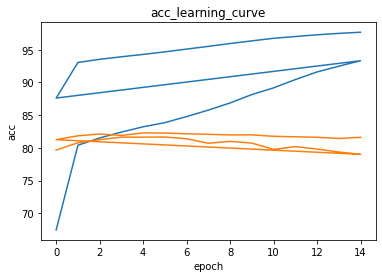

In [17]:
# semi
# 通過 torch.cuda.is_available() 的回傳值進行判斷是否有使用 GPU 的環境，如果有的話 device 就設為 "cuda"，沒有的話就設為 "cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 處理好各個 data 的路徑
train_with_label = os.path.join(path_prefix, 'training_label.txt')
train_no_label = os.path.join(path_prefix, 'training_nolabel.txt')
testing_data = os.path.join(path_prefix, 'testing_data.txt')
w2v_path = os.path.join(path_prefix, 'w2v_all.model') # 處理 word to vec model 的路徑

# 定義句子長度、要不要固定 embedding、batch 大小、要訓練幾個 epoch、learning rate 的值、model 的資料夾路徑
sen_len = 40
fix_embedding = True # fix embedding during training
batch_size = 128
epoch = 15
lr = 0.001
# model_dir = os.path.join(path_prefix, 'model/') # model directory for checkpoint model
model_dir = path_prefix # model directory for checkpoint model

print("loading data ...") # 把 'training_label.txt' 跟 'training_nolabel.txt' 讀進來
train_x, y = load_training_data('unsupervised', train_with_label)

################################處理 semi data #################################

train_x_no_label, y_semi = load_training_data('semi_supervised', train_no_label) #使用 semi
# 把沒有信心的 data 不要做 label 資料
train_x_no_label_good = []
y_semi_good = []
for i in range (len(train_x_no_label)):
  if(y_semi[i] == 1 or y_semi[i] == 0):
    train_x_no_label_good.append(train_x_no_label[i])
    y_semi_good.append(y_semi[i])

################################ 把unlabeled 拿來用 #############################

preprocess = Preprocess(train_x + train_x_no_label_good, sen_len, w2v_path=w2v_path)
embedding = preprocess.make_embedding(load=True)
train_x = preprocess.sentence_word2idx()
y = preprocess.labels_to_tensor(y + y_semi_good)

################################################################################

# 製作一個 model 的對象
model = LSTM_Net(embedding, embedding_dim=250, hidden_dim=150, num_layers=1, dropout=0.5, fix_embedding=fix_embedding)
model = model.to(device) # device為 "cuda"，model 使用 GPU 來訓練（餵進去的 inputs 也需要是 cuda tensor）

X_train, X_val, y_train, y_val = train_x[20000:500000], train_x[:20000], y[20000:500000], y[:20000]

# 把 data 做成 dataset 供 dataloader 取用
train_dataset = TwitterDataset(X=X_train, y=y_train)
val_dataset = TwitterDataset(X=X_val, y=y_val)

# 把 data 轉成 batch of tensors
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = batch_size,
                                            shuffle = True,
                                            num_workers = 8)

val_loader = torch.utils.data.DataLoader(dataset = val_dataset,
                                            batch_size = batch_size,
                                            shuffle = False,
                                            num_workers = 8)

# 開始訓練
training(batch_size, epoch, lr, model_dir, train_loader, val_loader, model, device)

### Test

In [18]:
# test.py
# 這個 block 用來對 testing_data.txt 做預測
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F

def testing(batch_size, test_loader, model, device):
    model.eval()
    ret_output = []
    with torch.no_grad():
        for i, inputs in enumerate(test_loader):
            inputs = inputs.to(device, dtype=torch.long)
            outputs = model(inputs)
            outputs = outputs.squeeze()
            outputs[outputs>=0.5] = 1 # 大於等於 0.5 為負面
            outputs[outputs<0.5] = 0 # 小於 0.5 為正面
            ret_output += outputs.int().tolist()
               
    return ret_output

### Predict test_data and Write to csv file

In [ ]:
# 開始測試模型並做預測
print("loading testing data ...")

test_x = load_testing_data(testing_data) #變成 list list
preprocess = Preprocess(test_x, sen_len, w2v_path=w2v_path)
embedding = preprocess.make_embedding(load=True)
test_x = preprocess.sentence_word2idx()
test_dataset = TwitterDataset(X=test_x, y=None)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                            batch_size = batch_size,
                                            shuffle = False,
                                            num_workers = 8)
print('\nload model ...')
model = torch.load(os.path.join(model_dir, 'ckpt.model'))
outputs = testing(batch_size, test_loader, model, device)

# 寫到 csv 檔案供上傳 Kaggle
tmp = pd.DataFrame({"id":[str(i) for i in range(len(test_x))],"label":outputs})
print("save csv ...")
tmp.to_csv(os.path.join(path_prefix, 'predict.csv'), index=False)
print("Finish Predicting")

# 以下是使用 command line 上傳到 Kaggle 的方式
# 需要先 pip install kaggle、Create API Token，詳細請看 https://github.com/Kaggle/kaggle-api 以及 https://www.kaggle.com/code1110/how-to-submit-from-google-colab
# kaggle competitions submit [competition-name] -f [csv file path]] -m [message]
# e.g., kaggle competitions submit ml-2020spring-hw4 -f output/predict.csv -m "......"